# I. Introduction
---
<br>
Nama    : Hadyan Yusuf Imran<br>
Batch   : HCK-025<br>
<br>

**Background**:
Forest fires are one of the environmental disasters that have a major impact on life. This disaster can cause ecosystem damage, air pollution, and threaten human safety. One solution that can be used for early mitigation is to utilize Computer Vision technology to automatically detect the presence of fire and smoke through images.

**Dataset**:
[Forest Fire, Smoke, and Non-Fire Image Dataset](https://www.kaggle.com/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset)

**Objectives**:
This project was created with the aim of building an image classification model using Convolutional Neural Network (CNN) that is able to detect the presence of fire, smoke, or non-fire conditions in forest images. This model is expected to help the forest fire early warning system through automatic visual analysis.

**Target User**: Local Government, Forestry Service, and Firefighters.
<br>

# II. Import Libraries
---

In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive

# Check TensorFlow version
print(tf.__version__)

2.18.0


# III. Data Loading
---

In [59]:
# Define hyperparameters
drive.mount('/content/drive')

train_path = '/content/drive/MyDrive/HACKTIV8/fire_smoke_dataset/train'
test_path = '/content/drive/MyDrive/HACKTIV8/fire_smoke_dataset/test'

img_height = 150
img_width = 150
batch_size = 126


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset has been separated into 3 folders, which facilitates the training, validation, and testing processes.

# IV. Feature Engineering
---

In [60]:
# Create batch generator for train-set, val-set, and test-set
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
																							class_mode='sparse',
																							subset='training',
																							batch_size=batch_size,
																							shuffle=True,
																							seed=10)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
																						class_mode='sparse',
																						subset='validation',
																						batch_size=batch_size,
																						shuffle=True,
																						seed=10)

test_datagen = ImageDataGenerator(rescale=1./255.)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
																						batch_size=batch_size,
																						shuffle=False,
																						seed=10)

Found 1258 images belonging to 3 classes.
Found 838 images belonging to 3 classes.
Found 450 images belonging to 3 classes.


This section carries out the process of creating a batch generator using **ImageDataGenerator** from Keras. This step is included in feature engineering to prepare data for creating models.

The following process are:
1. Normalization (Rescaling)
2. Split Validation (60% / 40%)
3. Generator Creation
4. Class Labels

With this setup, the image data is ready to be used by the CNN model.

In [61]:
# Show labels

print(train_set.class_indices)
print(test_set.class_indices)

{'fire': 0, 'non-fire': 1, 'smoke': 2}
{'fire': 0, 'non-fire': 1, 'smoke': 2}


Create label for each class, which is 0 for Fire, 1 for Non Fire, and 2 for Smoke.

# V. Exploratory Data Analysis (EDA)
---

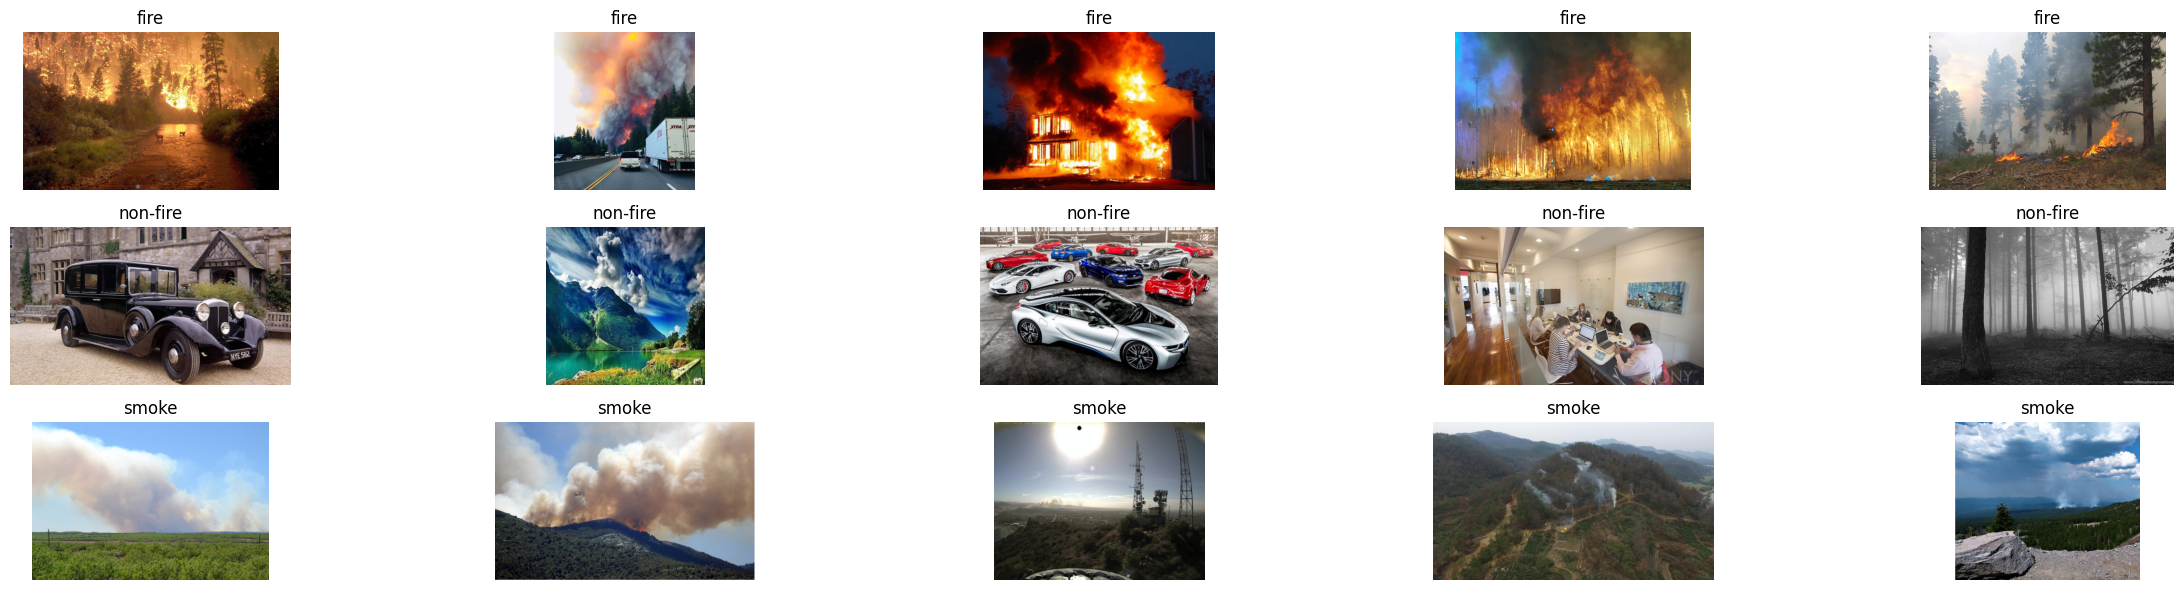

In [62]:
# Show several images of train-set
fig, axs = plt.subplots(3, 5, figsize=(25, 6))

classes = ['fire', 'non-fire', 'smoke']

for i, cls in enumerate(classes):
    img_dir = os.path.join(train_path, cls)
    img_files = [f for f in os.listdir(img_dir) if not f.startswith('.')][:5]  # First 5 images

    for j in range(5):
        img_path = os.path.join(img_dir, img_files[j])
        img = Image.open(img_path)
        axs[i][j].imshow(img)
        axs[i][j].set_title(f"{cls}")
        axs[i][j].axis('off')

plt.tight_layout()
plt.show()

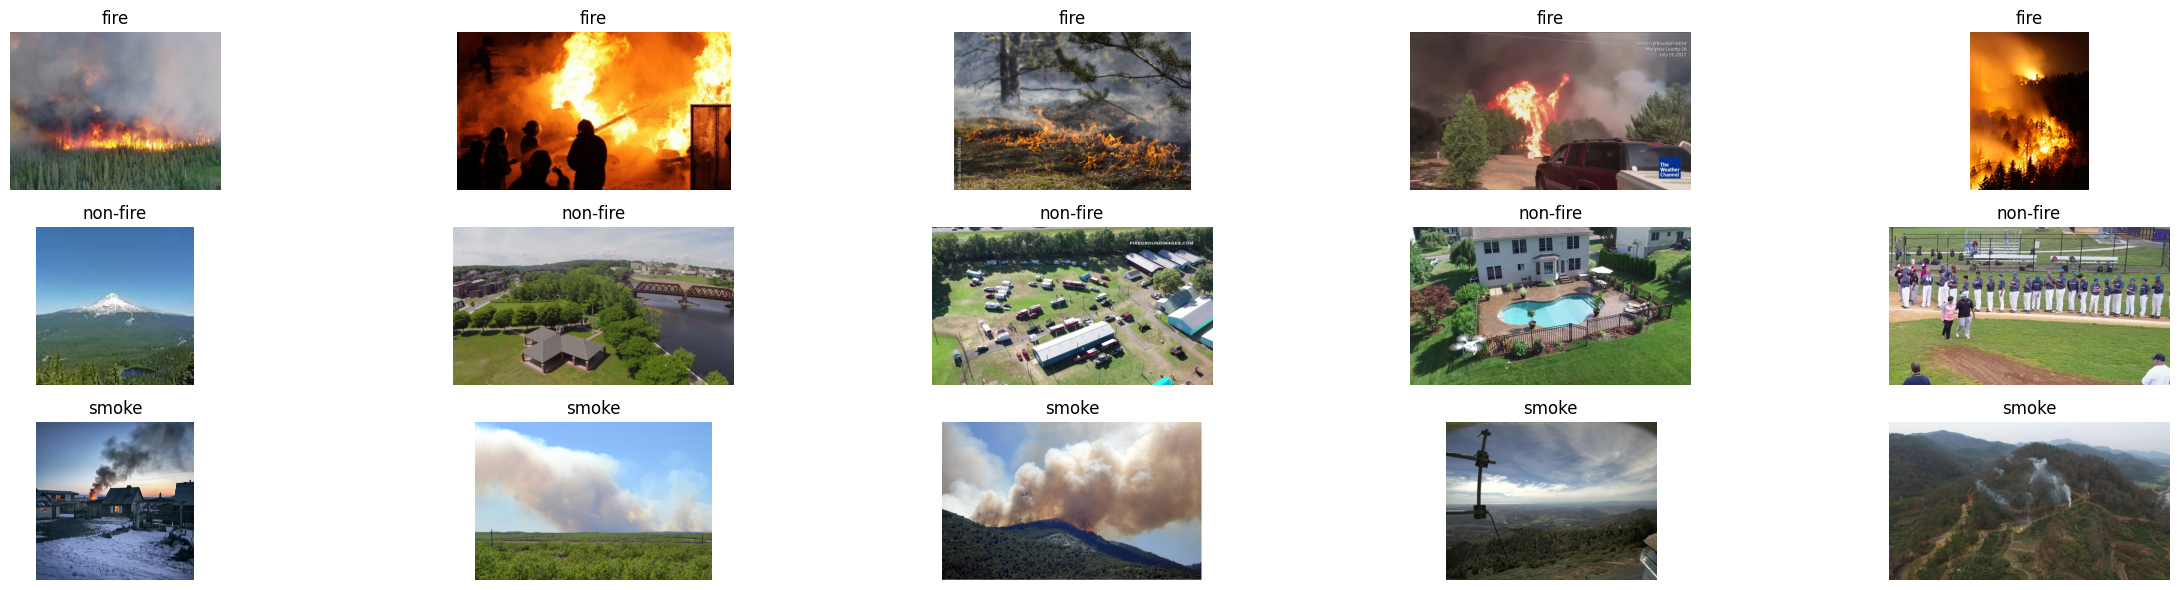

In [18]:
# Show several images of test-set
fig, axs = plt.subplots(3, 5, figsize=(25, 6))

classes = ['fire', 'non-fire', 'smoke']

for i, cls in enumerate(classes):
    img_dir = os.path.join(test_path, cls)
    img_files = [f for f in os.listdir(img_dir) if not f.startswith('.')][:5]  # First 5 images

    for j in range(5):
        img_path = os.path.join(img_dir, img_files[j])
        img = Image.open(img_path)
        axs[i][j].imshow(img)
        axs[i][j].set_title(f"{cls}")
        axs[i][j].axis('off')

plt.tight_layout()
plt.show()

**Class Fire**: Defined by the dominant colors of bright red and orange, often accompanied by forms of burning flames or spreading flames. The characteristic of this class is the high intensity of light and a clearly visible burning pattern defining the presence of an active fire.<br><br>

**Smoke class**: Defined by a whitish gray color that covers the image area. Its shape obscures the objects behind it. The uniqueness of this class lies in its opaque texture and transparent gradation, which indicates the presence of fire smoke.<br><br>

**Non-fire class**: Defined as an image without any indication of fire or smoke, usually showing a calm forest scene with a blue sky. There are no flaming shapes or smoke haze. Its visual calmness clearly distinguishes it from the other two classes.

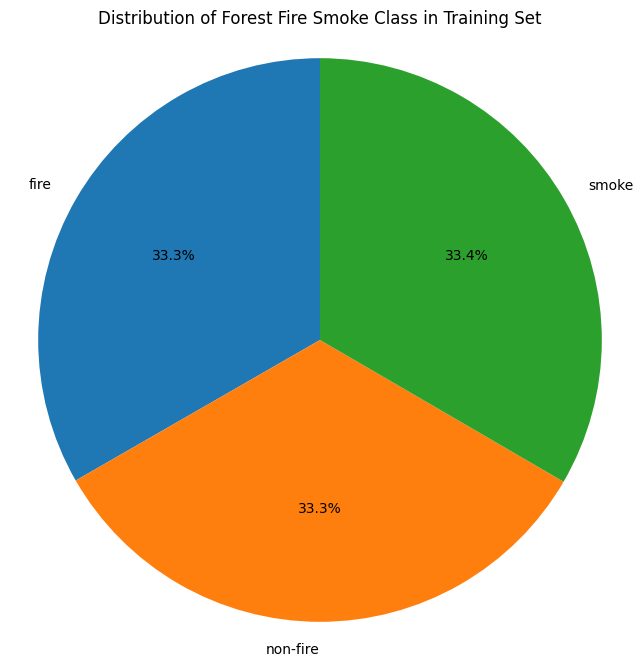

In [63]:
class_counts = train_set.classes
class_labels = list(train_set.class_indices.keys())

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(np.bincount(class_counts), labels=class_labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Forest Fire Smoke Class in Training Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

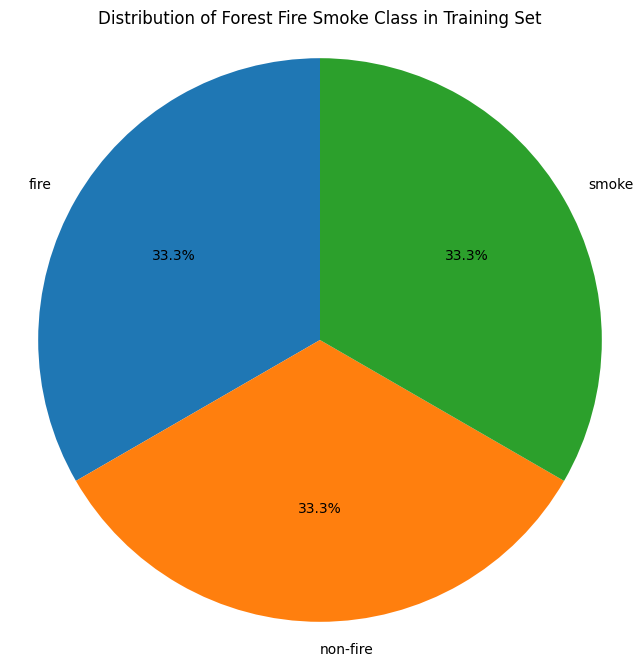

In [64]:
class_counts = test_set.classes
class_labels = list(train_set.class_indices.keys())

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(np.bincount(class_counts), labels=class_labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Forest Fire Smoke Class in Training Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Class Distribution in Training and Test Set
- The figure above shows the data distribution in the training set for three classes: fire, smoke, and non-fire.

- Each class has almost the same proportion, which is around 33.3%.

- This shows that the dataset is balanced, so the model does not need to be given special treatment such as oversampling or undersampling to overcome class imbalance (imbalanced data).

# V. Modeling
---

## V. A. - Model Definition

In [65]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [66]:
# Create Sequential API model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(128, (3,3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,374 (634.27 KB)

 Trainable params: 162,374 (634.27 KB)

 Non-trainable params: 0 (0.00 B)

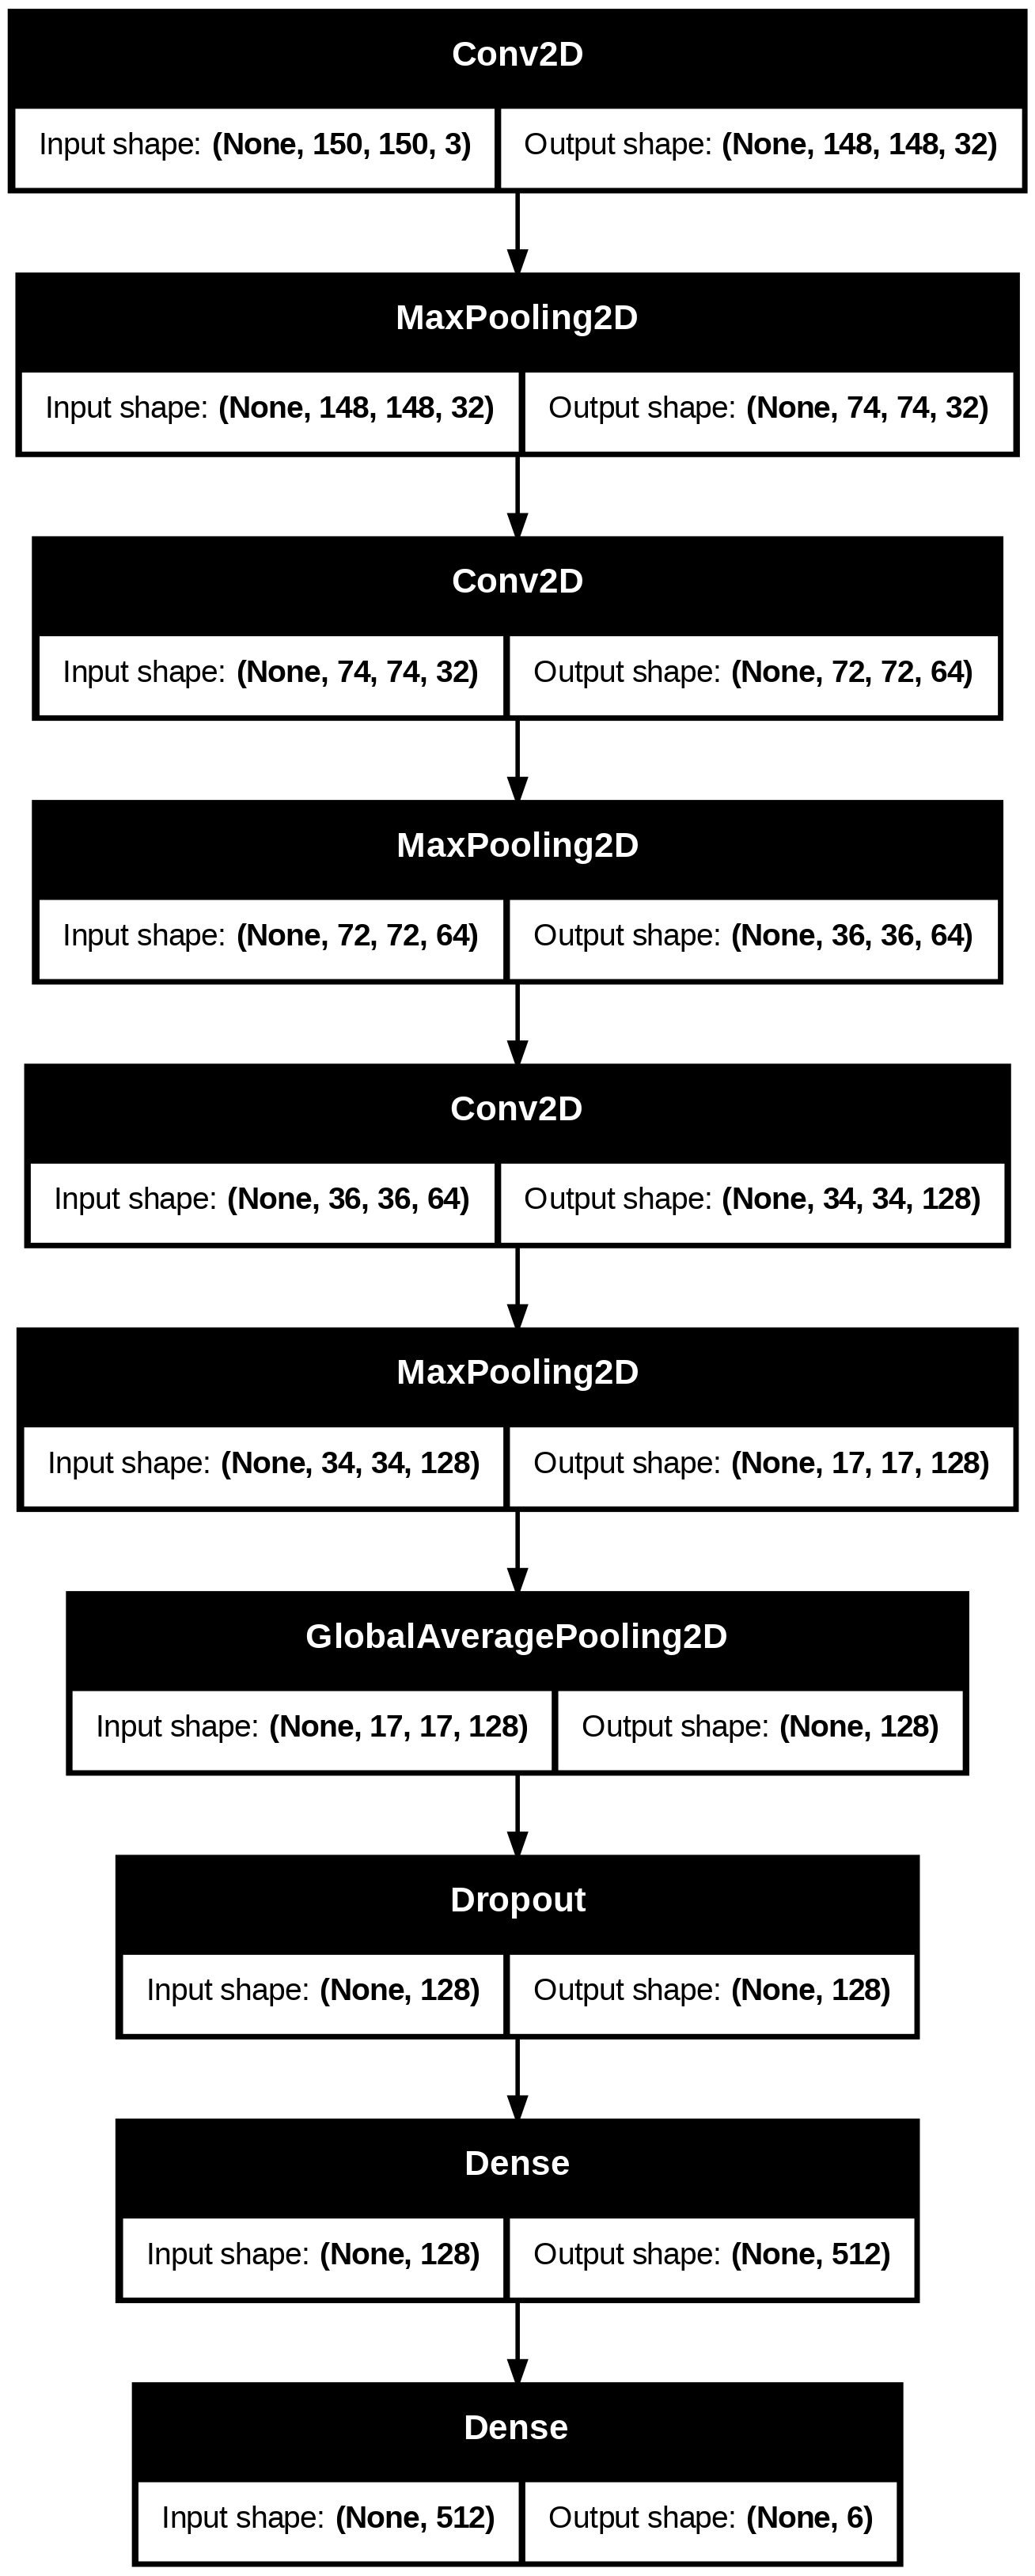

In [67]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

## V. B. - Model Training

In [24]:
# Train the model

epoch = 25
history = model.fit(train_set, epochs=epoch, steps_per_epoch=20, validation_data=val_set, verbose=1, validation_steps=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
10/20 ━━━━━━━━━━━━━━━━━━━━ 1:26 9s/step - accuracy: 0.3194 - loss: 1.6020

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.3366 - loss: 1.5003 - val_accuracy: 0.5556 - val_loss: 1.0188
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.5155 - loss: 0.9892 - val_accuracy: 0.7167 - val_loss: 0.7305
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.6790 - loss: 0.7875 - val_accuracy: 0.7611 - val_loss: 0.6274
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.7472 - loss: 0.6725 - val_accuracy: 0.8056 - val_loss: 0.5717
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.7577 - loss: 0.6405 - val_accuracy: 0.7833 - val_loss: 0.6711
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8013 - loss: 0.5778 - val_accuracy: 0.7778 - val_loss: 0.6332
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.8144 - loss: 0.5337 - val_accuracy: 0.7556 - val_loss: 0.7011
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.8155 - loss: 0.5317 - val_accuracy: 0.7611 - val_loss: 0.6

## V. C. - Model Evaluation

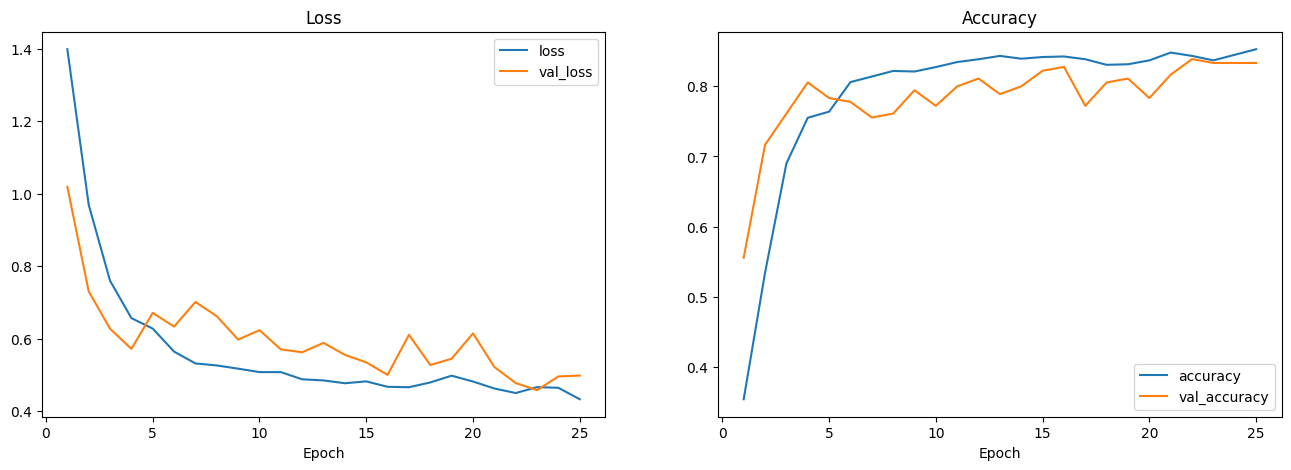

In [25]:
# Plot training results

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1, epoch+1), history.history['loss'], label='loss')
ax[0].plot(range(1, epoch+1), history.history['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1, epoch+1), history.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch+1), history.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

# VI. - Model Improvement
---

## VI.A - Model Definition

In [71]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [72]:
# Model Improvement
input_layer = Input(shape=(img_height, img_width, 3))

model_imp = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
model_imp = layers.BatchNormalization()(model_imp)
model_imp = layers.MaxPooling2D(2, 2)(model_imp)

model_imp = layers.Conv2D(64, (3,3), activation='relu', padding='same')(model_imp)
model_imp = layers.BatchNormalization()(model_imp)
model_imp = layers.MaxPooling2D(2, 2)(model_imp)

model_imp = layers.Conv2D(128, (3,3), activation='relu', padding='same')(model_imp)
model_imp = layers.BatchNormalization()(model_imp)
model_imp = layers.MaxPooling2D(2, 2)(model_imp)

model_imp = layers.GlobalAveragePooling2D()(model_imp)
model_imp = layers.Dropout(0.5)(model_imp)
xmodel_imp = layers.Dense(512, activation='relu')(model_imp)
model_imp = layers.Dropout(0.3)(model_imp)

output_layer = layers.Dense(6, activation='softmax')(model_imp)

model_improved = models.Model(inputs=input_layer, outputs=output_layer)

model_improved.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

model_improved.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,918 (370.77 KB)

 Trainable params: 94,470 (369.02 KB)

 Non-trainable params: 448 (1.75 KB)

## VI.B - Model Training

In [73]:
history_improved = model_improved.fit(train_set,
                                      epochs=25,
                                      validation_data=val_set)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 565s 60s/step - accuracy: 0.5441 - loss: 1.5148 - val_accuracy: 0.6265 - val_loss: 1.6873
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 184s 18s/step - accuracy: 0.7909 - loss: 0.6679 - val_accuracy: 0.3878 - val_loss: 1.6337
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 169s 17s/step - accuracy: 0.8311 - loss: 0.5987 - val_accuracy: 0.3532 - val_loss: 1.6606
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 169s 17s/step - accuracy: 0.8490 - loss: 0.5056 - val_accuracy: 0.3341 - val_loss: 1.7092
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 185s 19s/step - accuracy: 0.8471 - loss: 0.5438 - val_accuracy: 0.3341 - val_loss: 1.7947
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 170s 17s/step - accuracy: 0.8638 - loss: 0.4604 - val_accuracy: 0.3341 - val_loss: 1.9040
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 170s 17s/step - accuracy: 0.8555 - loss: 0.4782 - val_accuracy: 0.3341 - val_loss: 2.0268
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 181s 18s/step - accuracy: 0.8426 - loss: 0.4791 - val_accuracy: 0.

## VI.C - Model Evaluation

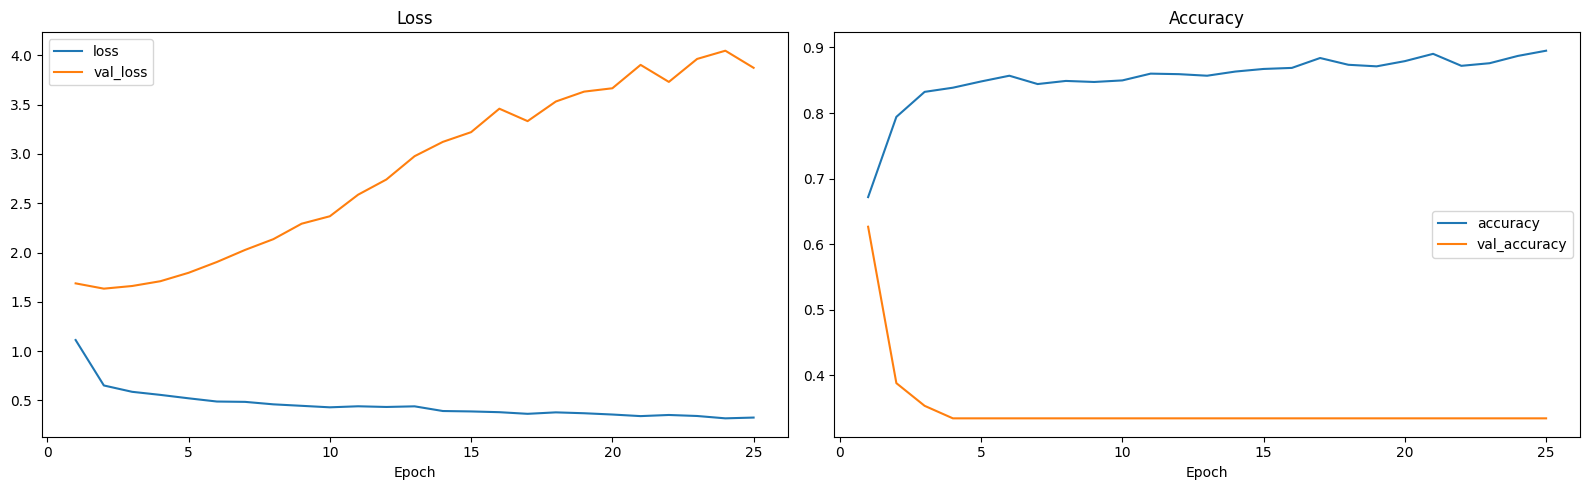

In [74]:
# Create history dataframe
history_aug_df = pd.DataFrame(history_improved.history)
epoch = len(history_aug_df)

# Plot training results
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))

# Plot loss
ax[0].plot(range(1, epoch+1), history_aug_df['loss'], label='loss')
ax[0].plot(range(1, epoch+1), history_aug_df['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# Plot accuracy
ax[1].plot(range(1, epoch+1), history_aug_df['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch+1), history_aug_df['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()


# VII. Model Saving
---

In [75]:
model_aug.save('best_model.h5')
print("Model saved as best_model.h5")

Model saved as best_model.h5


# VIII. Conclusion
---

In this project, an image classification system based on Convolutional Neural Network (CNN) has been successfully built to detect forest fires through visual images. Two architectural approaches are used:<br>
- Model 1 (Baseline) — using Sequential API with a simple CNN architecture.
- Model 2 (Improved) — using a more flexible Functional API, equipped with additional data augmentation and regularization techniques such as batch normalization and dropout.<br>

The training and evaluation process shows that Model 2 is better in validation accuracy and stability, and is better able to avoid overfitting compared to the initial model.<br>

This project proves that CNN can be an effective solution in automatically detecting forest fires, which in the future has the potential to be integrated into real-time monitoring systems based on cameras, drones, or satellite imagery. This will be very useful for government agencies, rescue agencies, and forestry companies in disaster mitigation and environmental protection efforts.
